## Working on pulling edge statistics from images

#### Resources and ideas
* https://akshaysin.github.io/fourier_lpf.html#.XHwzzohKhPb -- using Pass filters to change the output images

### Intial Forier Transform -- From Practice- Forier Transform

In [2]:
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy
from scipy.ndimage import gaussian_filter


In [3]:
im = Image.open('Test_Photo_fromMike.png').convert('L')

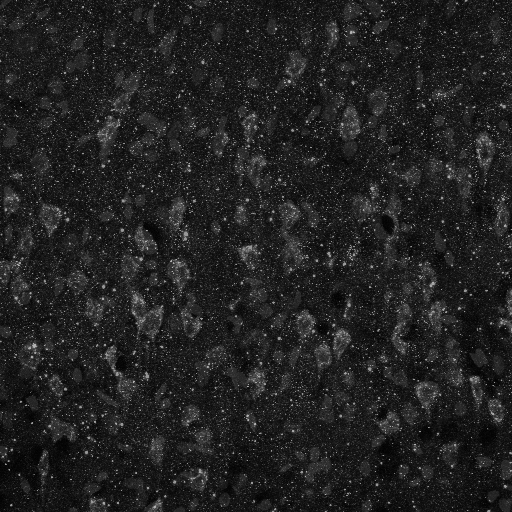

In [4]:
im

<function matplotlib.pyplot.show(*args, **kw)>

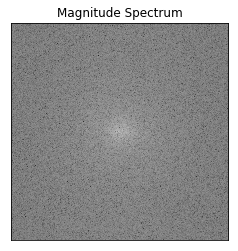

In [5]:
#two dimensional forier transform from numpy
f = np.fft.fft2(im)

fshift = np.fft.fftshift(f) #moves origin to center

magnitude_spectrum = np.log(np.abs(fshift))


#plotting of image
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show

#### Split Colors


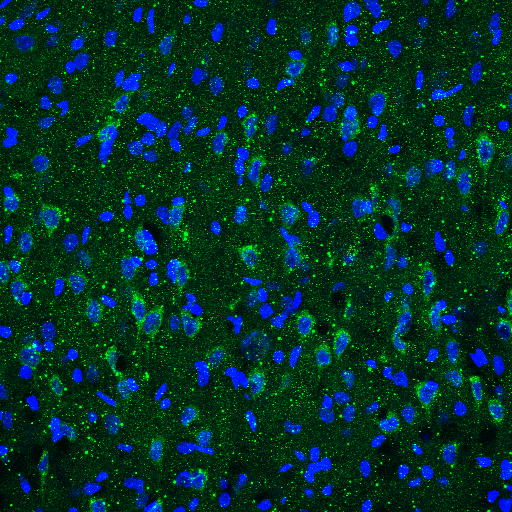

In [6]:
im_color = Image.open('Test_Photo_fromMike.png')
im_color

In [7]:
r,g,b = im_color.split()

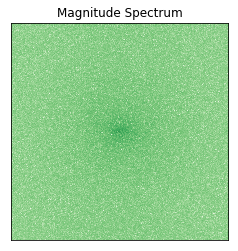

In [8]:
f_green = np.fft.fft2(g)
fshift_green = np.fft.fftshift(f_green)
m_spec_green = np.log(np.abs(fshift_green))

plt.imshow(m_spec_green, cmap = 'Greens')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

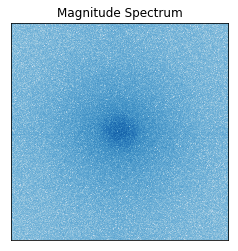

In [9]:
f_blue = np.fft.fft2(b)
fshift_blue = np.fft.fftshift(f_blue)
m_spec_blue = np.log(np.abs(fshift_blue))

plt.imshow(m_spec_blue, cmap = 'Blues')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

# Edge Statistics on Specific colors

### Filters

Filters are used to find edge statistics as the grouping of the frequencys in a shifted FFT cluster the low and high frequencys - the low frequencys are grouped in the center of the image while the high frequencys are scattered around the image itself. By masking only certian areas of the FFT we can selectively exclude groups of frequencys and change the un-transformed image

### Using High Pass Filters (HPF)
High pass filters are circular masks with a center circle of value zero with all remaining values being one - denotes edges which usually have a higher frequency than the center portions.

In [16]:
#we will build an array that is covers the entire image as a mask 

#determines the pixels in the rows and columns
row, column = im.size 

#the mask will be placed in the center so we need to know where the center is
center_row = int(row/2)
center_column = int(column/2)
center = [center_row, center_column]

#for a HPF all other remaining values are one so we need to bulid an orginal array of 
#all one in the size of the photograph
ones_mask = np.ones((row, column))

#radius of the circle that is blocked out - can be changed to refine edges
r=80

#in order to create the circle of zeros we need to index an array of the same size as the image

x, y = np.ogrid[:row,:column]

#equation of circle is x^2 + y^2 = r^2 - need to have a circle of zeros at the center of the image the less than fills the circle in to the origion
zero_circle = (x - center_row) ** 2 + (y - center_column) ** 2 <= r*r

#now the last step to create the mask is the overlay the zero_circle on the ones mask
ones_mask[zero_circle] = 0

# we still need to apply the mask to the fourier transform
hpf_fshift_blue = fshift_blue * ones_mask

#scales it all to a certian range (???)
m_spec_hpf_blue = np.log(np.abs(hpf_fshift_blue))


In [ ]:
hpf_im = np.fft.ifft(ones_mask)

### Using Low Pass Filter (LPF)
Low pass filters are also circular masks but with a center value of one with all other values of zero - usually used to denote smooth regions can help point out edges but is not best for that. 

### Using Band Pass Filters
Mix of low and High Pass filters that filter the high and low frequency leaving middle frequencys


### Pulling stastistics from images